In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST("./", train=True, download=True, transform= transform)

train_data = DataLoader(dataset, batch_size=64, shuffle=False)

In [3]:
class Generator(nn.Module):
    def __init__(self, random_dim, img_dim=784):
        super().__init__()
        
        self.random_dim = random_dim # hyper parameter
        self.img_dim = img_dim # 784 - Fashion MNIST
        
        self.g_theta = nn.Sequential(
            nn.Linear(self.random_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, self.img_dim),
            nn.Tanh() # To keep the values b/n 1 and -1, similar to training data
        )
        
    
    def forward(self, z):
        return self.g_theta(z)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super().__init__()
        
        self.img_dim = img_dim
        
        self.D_w = nn.Sequential(
            nn.Linear(self.img_dim, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid() # To get the probability value b/n [0, 1]
        )
        
    def forward(self, images):
        return self.D_w(images)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
image_dim = 784 # Fashion MNIST images = 28 x 28
random_noise_dim = 150 # Hyper parameter

generator = Generator(random_noise_dim, image_dim).to(device)
discriminator = Discriminator(image_dim).to(device)
generator, discriminator

(Generator(
   (g_theta): Sequential(
     (0): Linear(in_features=150, out_features=256, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=256, out_features=512, bias=True)
     (3): LeakyReLU(negative_slope=0.01)
     (4): Linear(in_features=512, out_features=784, bias=True)
     (5): Tanh()
   )
 ),
 Discriminator(
   (D_w): Sequential(
     (0): Linear(in_features=784, out_features=512, bias=True)
     (1): LeakyReLU(negative_slope=0.01)
     (2): Linear(in_features=512, out_features=256, bias=True)
     (3): LeakyReLU(negative_slope=0.01)
     (4): Linear(in_features=256, out_features=1, bias=True)
     (5): Sigmoid()
   )
 ))

In [7]:
criterion = nn.BCELoss() # Loss function, since discriminator solves a binary classification problem

generator_optimizer = optim.Adam(generator.parameters(), lr=1e-3)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-3)

In [8]:

def show_generated_images(epoch, generator, fixed_noise):
    generator.eval()
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).reshape(-1, 1, 28, 28)
        fake_imgs = fake_imgs * 0.5 + 0.5  # De-normalize

    grid = torchvision.utils.make_grid(fake_imgs, nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f'Generated Images at Epoch {epoch}')
    plt.axis('off')
    plt.show()
    generator.train()

In [9]:
fixed_random_samples = torch.randn(64, random_noise_dim).to(device) # samples to check the output generated by generator across epochs.

Epoch [10/100], D_loss: 0.4335, G_loss: 2.2331


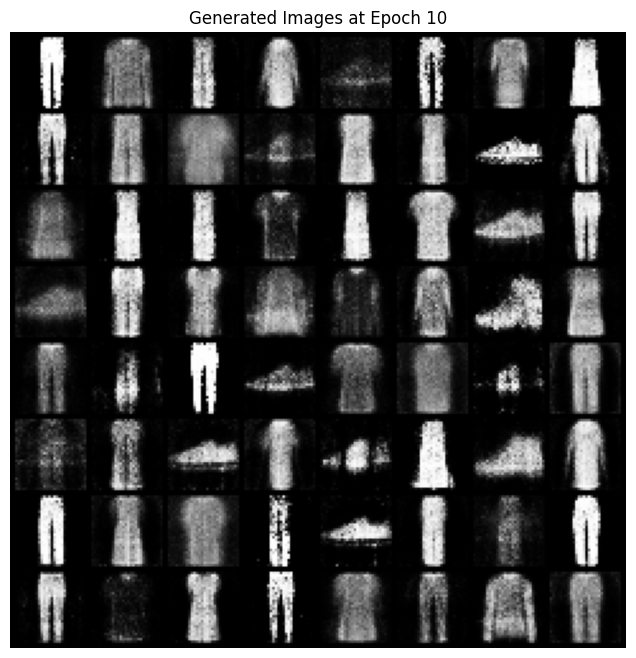

Epoch [20/100], D_loss: 0.9545, G_loss: 2.0305


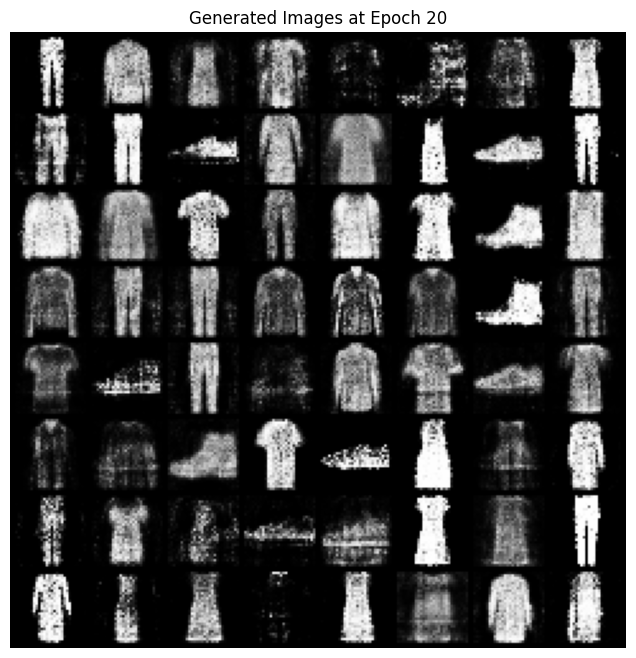

Epoch [30/100], D_loss: 1.2535, G_loss: 1.4033


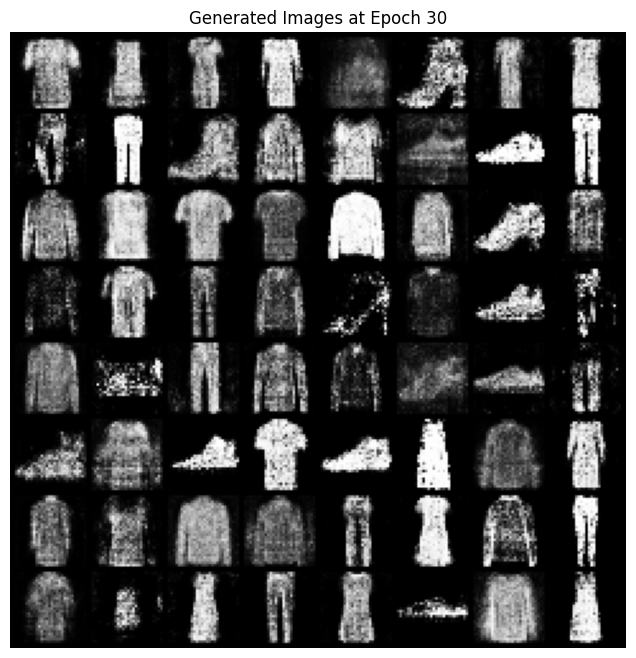

Epoch [40/100], D_loss: 0.9055, G_loss: 1.2218


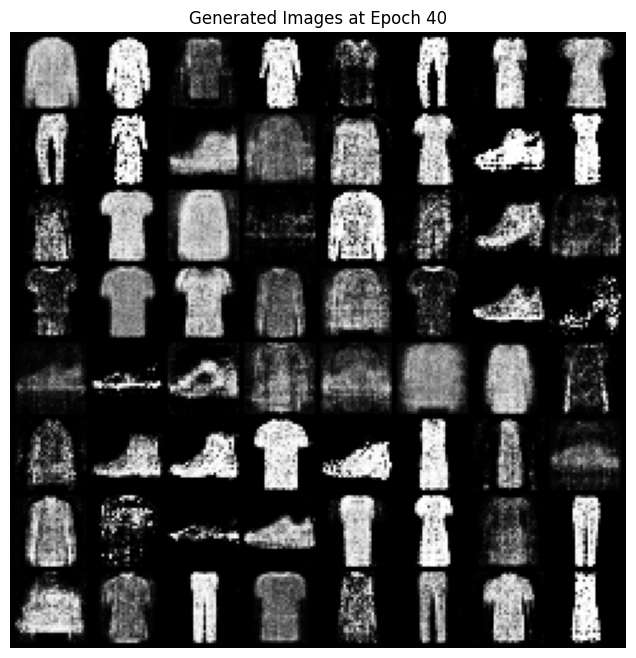

Epoch [50/100], D_loss: 1.0084, G_loss: 1.2052


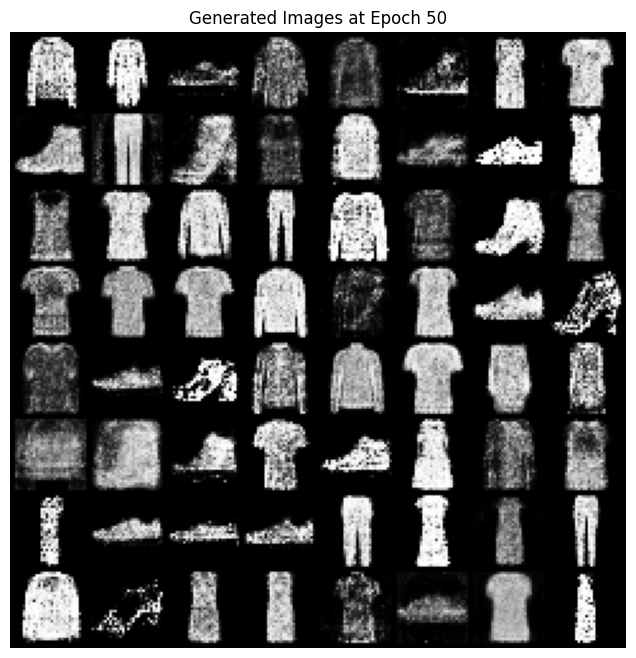

Epoch [60/100], D_loss: 1.2215, G_loss: 1.8508


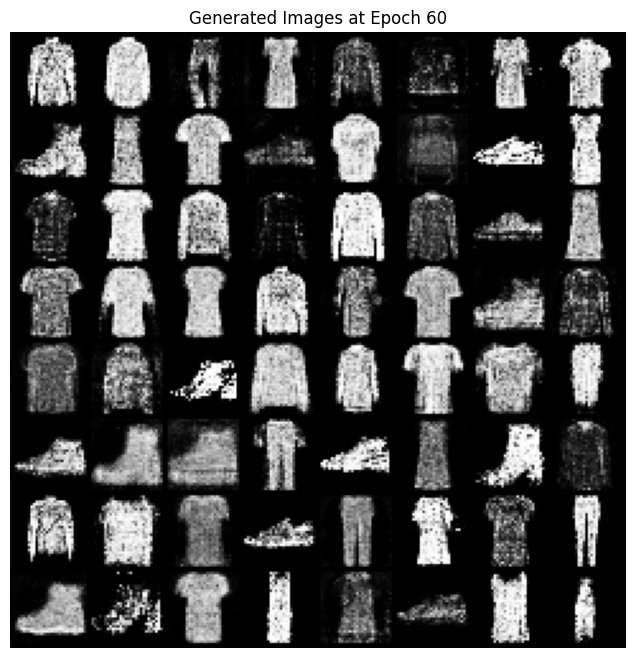

Epoch [70/100], D_loss: 1.1425, G_loss: 1.4475


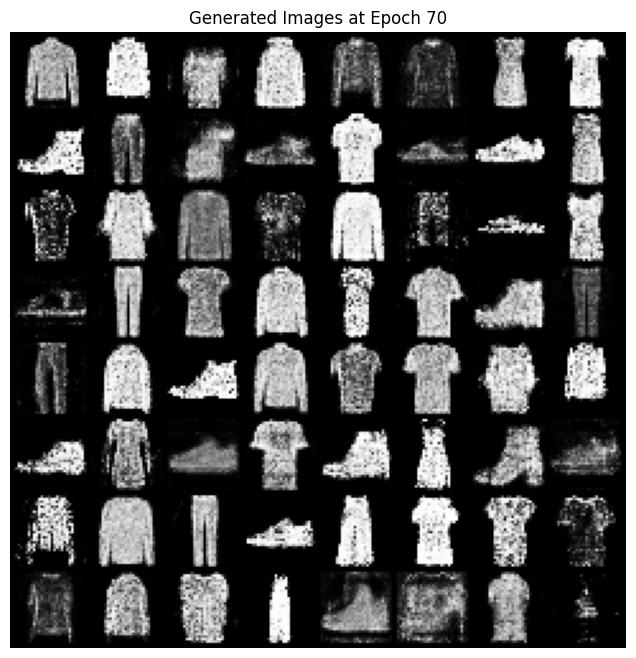

Epoch [80/100], D_loss: 0.8142, G_loss: 1.4827


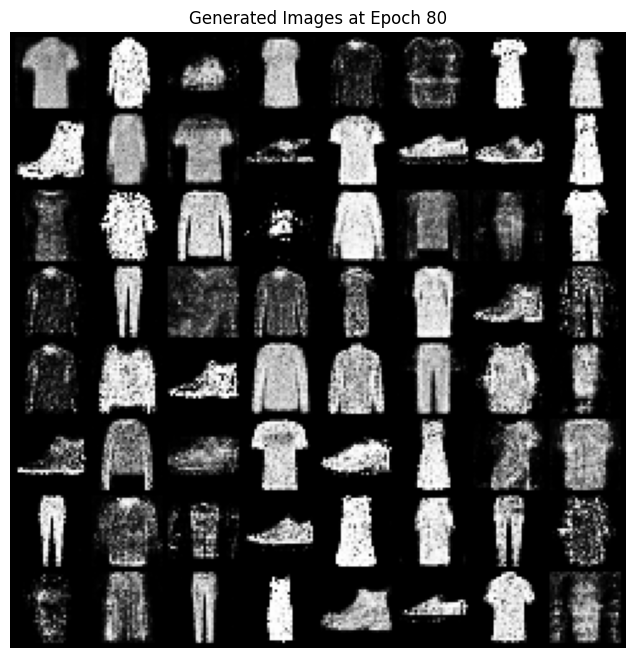

Epoch [90/100], D_loss: 1.0582, G_loss: 1.4126


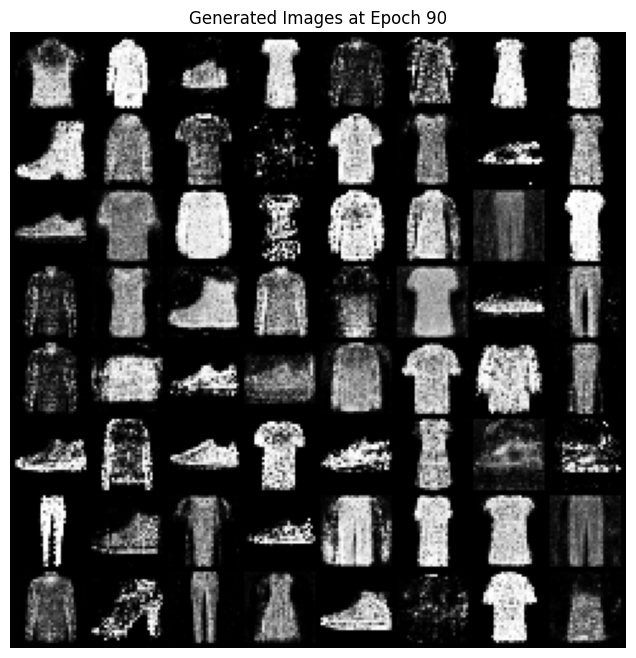

Epoch [100/100], D_loss: 0.8561, G_loss: 1.3053


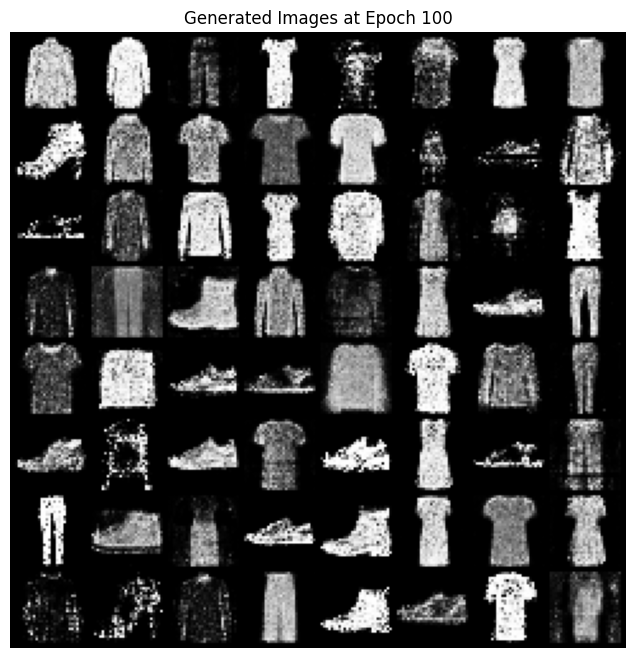

In [10]:
epochs = 100

for epoch in range(epochs):
    for idx, (data, label) in enumerate(train_data):
        batch_size = data.shape[0]
        
        # Creating the labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        data = data.view(batch_size, -1).to(device) # flattening the data such that it matches the Neural N/w input requirements
        
        # Training the discriminator
        
        """Real Samples"""
        output_r = discriminator(data)
        loss_r = criterion(output_r, real_labels) # making sure discriminator learns to identify the samples from dataset
        
        """Generated Samples"""
        z = torch.randn(batch_size, random_noise_dim).to(device)
        generated_samples = generator(z)
        
        output_g = discriminator(generated_samples.detach())
        loss_g = criterion(output_g, fake_labels) # learns to identify samples by generator; but dont penalize generator therefore the detach.
        
        disc_loss = loss_r + loss_g # Total discriminator loss
        
        discriminator_optimizer.zero_grad()
        disc_loss.backward()
        discriminator_optimizer.step() # update parameters of the discriminator
        
        # Training the generator
        z = torch.randn(batch_size, random_noise_dim).to(device)
        
        generated_samples = generator(z)
        output_g = discriminator(generated_samples)
        g_loss = criterion(output_g, real_labels) # Tricking the discriminator, i.e., tweaking generator such that discriminator assigns value close to 1
        
        generator_optimizer.zero_grad()
        g_loss.backward()
        generator_optimizer.step() # update the parameters of generator
        
    if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], D_loss: {disc_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
            show_generated_images(epoch+1, generator, fixed_random_samples)